In [170]:
#Libraries we are using (might add more later)
import torch #Pytorch
import matplotlib as plt #Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns #Seaborn
import numpy as np
import pandas as pd
import math as math
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split # Splits data into training/testing sets
from sklearn.preprocessing import StandardScaler #scales data for better preformance

# Electric Power Consumption 
The data set for this project can be found [here](https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption).\
The goal of the project is to create a model that accurately predicts kWh from a specified zone with an acceptable error rate of 1000 kWh

In [171]:
df = pd.read_csv('powerconsumption.csv')
print(f'Features: {df.columns} \nShape: {df.shape}')

Features: Index(['Datetime', 'Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3'],
      dtype='object') 
Shape: (52416, 9)


In [172]:
display(df)

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [173]:
# Split the date column into numbers that can be analyzed
df[['Date', 'Time']] = df['Datetime'].str.split(" ", expand=True)
df = df.drop('Datetime',axis=1)
col = df.pop('Date')
df.insert(0,'Date',col)
col = df.pop('Time')
df.insert(1,'Time',col)
#Power Stats
print(f'Lowest Power Recorded: {df['PowerConsumption_Zone1'].min()}')
print(f'Highest Power Recorded: {df['PowerConsumption_Zone1'].max()}')

Lowest Power Recorded: 13895.6962
Highest Power Recorded: 52204.39512


In [174]:
dfs = df.copy()
# The following code splits up the date and organizes them

dfs[['Month','Day','Year']] = df['Date'].str.split("/",expand=True)
dfs[['Month', 'Day', 'Year']] = dfs[['Month', 'Day', 'Year']].astype(int)
dfs = dfs.drop(['Date'],axis=1)
dfs['Time'] = pd.to_datetime(dfs['Time'], format='%H:%M')
dfs['Time'] = dfs['Time'].dt.round('h').dt.hour
dfs = dfs.drop('Year',axis=1)
col = dfs.pop('Day')
dfs.insert(0,'Day',col)
col = dfs.pop('Month')
dfs.insert(0,'Month',col)
dfs = dfs.drop(['PowerConsumption_Zone2',"PowerConsumption_Zone3"],axis=1)
display(dfs)

,Month,Day,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1
0,1,1,0,6.559,73.8,0.083,0.051,0.119,34055.69620
1,1,1,0,6.414,74.5,0.083,0.070,0.085,29814.68354
2,1,1,0,6.313,74.5,0.080,0.062,0.100,29128.10127
3,1,1,0,6.121,75.0,0.083,0.091,0.096,28228.86076
4,1,1,1,5.921,75.7,0.081,0.048,0.085,27335.69620
...,...,...,...,...,...,...,...,...,...
52411,12,30,23,7.010,72.4,0.080,0.040,0.096,31160.45627
52412,12,30,23,6.947,72.6,0.082,0.051,0.093,30430.41825
52413,12,30,0,6.900,72.8,0.086,0.084,0.074,29590.87452
52414,12,30,0,6.758,73.0,0.080,0.066,0.089,28958.17490


In [175]:
# Round the Power data to 4 digits (ie 34055 turns intol 34050 so we work with a lot less outputs)
dfs['PowerConsumption_Zone1'] = (df['PowerConsumption_Zone1']/100000).round(4) * 100000
#We can divide it out here since the leading 0 does not change the data this will help us reduce the amount of outputs making it easier to train
dfs['PowerConsumption_Zone1']=dfs['PowerConsumption_Zone1'].div(10)

print(f'Unique values of PowerConsumption after rounding: {dfs['PowerConsumption_Zone1'].nunique()}')

Unique values of PowerConsumption after rounding: 3268


In [176]:
# Just moves the training to the GPU if its available
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#### Simple Neural Network

For a simple neural network, we will be creating a Neural Network that trains on one Zone at a time\
The reLU function is used to introduce nonlinearity to solve gradient issues\
This neural network will have 4 layers, with a drop out function after the first 3\
Adding a dropout help prevent overfitting by randomly nullifying outputs from neurons during the training process \
This helps / encourages the network to learn redundant representations for everything and increases the model to generalize  

In [177]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100,150)
        self.fc3 = nn.Linear(150,300)
        self.fc4 = nn.Linear(300, output_size+20)  # 20 extra for safety     
        self.drp = nn.Dropout(p=0.1,inplace=False)
       
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drp(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.drp(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.drp(x)
        x = self.fc4(x)
        return x


In [178]:
#The features are normalized using Standard Scaler
def trainSplit(X,y):
    scalar = StandardScaler()


    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

    X_train = scalar.fit_transform(X_train)
    X_test = scalar.transform(X_test)


    #converts to pytorch tensors and moves them to the device we selected


    X_train_tensor = (torch.tensor(X_train,dtype=torch.float32)).to(device)
    X_test_tensor = (torch.tensor(X_test,dtype=torch.float32)).to(device)

    y_train_tensor = (torch.tensor(y_train,dtype=torch.long)).to(device)
    y_test_tensor = (torch.tensor(y_test,dtype=torch.long)).to(device)

    return X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor


In [179]:
def train(X_train_tensor,y_train_tensor,model,filename=None,num_epocs=None):

    #Default num_epocs if none are specified
    if num_epocs is None:
        num_epocs = 50        

    #Loss function and optimizer
    lossF = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=0.01)

    for epoch in range(num_epocs):
        outputs = model(X_train_tensor)
        loss = lossF(outputs,y_train_tensor)

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

    #Save the model if a file name is given
    if filename is not None:
        torch.save(model,filename)
        print(f'Saved model as: {filename}')
    

In [180]:
def printResults(model,X_test_tensor,y_test_tensor,error=None):
    if error is None:
        error = 100
    else:
        error = error/10
    with torch.no_grad():  
        outputs = model(X_test_tensor)  
        _, predicted = torch.max(outputs, 1) 

        # Calculate accuracy
        correct = (abs(predicted - y_test_tensor) < error).sum().item()  
        print(f'Correct: {correct}/{y_test_tensor.size(0)}')
        accuracy = correct / y_test_tensor.size(0)  
        print(f'Accuracy on test data: {accuracy * 100:.2f}%')

        predicted = predicted.cpu()
        y_test_tensor = y_test_tensor.cpu()
        predicted_values = (predicted.numpy() + y.min()) * 10
        actual_values = (y_test_tensor.numpy() + y.min()) * 10

        data = pd.DataFrame({
            'Actual': actual_values,
            'Predicted': predicted_values
        })

        fig, ax = plt.subplots(figsize=(10, 6))  


        ax.scatter(data['Actual'], data['Predicted'], alpha=0.6, label='Data points')


        ax.plot(
            [data['Actual'].min(), data['Actual'].max()],
            [data['Actual'].min(), data['Actual'].max()],
            color='red',
            label='Ideal fit'
        )


        ax.set_title('Actual vs Predicted Values') 
        ax.set_xlabel('Actual Values')  
        ax.set_ylabel('Predicted Values')  
        ax.legend()
        ax.grid(True)

    return ax

In [181]:
def loadModel(modelName):
    model = torch.load(modelName,weights_only=True)
    model.eval()
    return model

In [182]:

torch.serialization.add_safe_globals([SimpleNeuralNetwork])
torch.serialization.add_safe_globals([set])
torch.serialization.add_safe_globals([torch.nn.modules.activation.ReLU])
torch.serialization.add_safe_globals([torch.nn.modules.linear.Linear])
torch.serialization.add_safe_globals([torch.nn.modules.dropout.Dropout])

In [183]:
X1 = dfs[['Month','Day','Time','Temperature','Humidity','WindSpeed']].to_numpy()
y = dfs['PowerConsumption_Zone1'].to_numpy()
y = y - y.min()
inputSize = X1[0].size
outputSize = int(y.max())

X1_train_tensor,y1_train_tensor,X1_test_tensor,y1_test_tensor = trainSplit(X1,y)
#model = SimpleNeuralNetwork(inputSize,outputSize).to(device)
#train(X1_train_tensor,y1_train_tensor,model,"ModelWithoutFeatures",num_epocs=150)

Correct: 6371/10484
Accuracy on test data: 60.77%


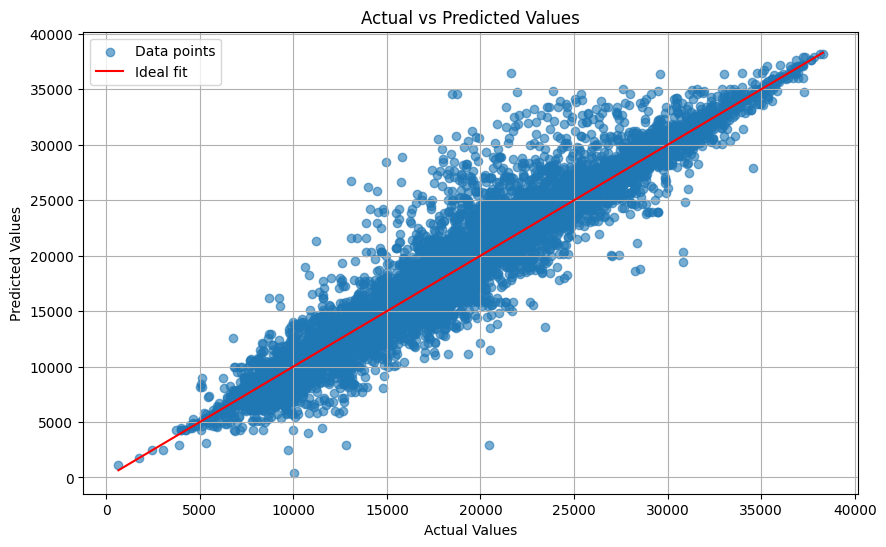

In [184]:
printResults(loadModel("ModelWithoutFeatures"),X1_test_tensor,y1_test_tensor,error=1000)
plt.show()

### **Feature Engineering**

Since our data is sequential, there are some adjustments that can be made 

- Incorporate lag features
     - We added 3 lag features that depict the power output from the previous days. This will help our model accurately predict today's power output because today's power output is heavily influenced by the features that resulted in the power output of those days. Essentially just giving our network more data to rely on

- Map time data using sin/cos functions
    - Using time in the traditional way is a problem because say the end of the month (30) and the start of the next month (1) are closely related, this is not apparent to the neural network. When we use the sin/cos functions we can adjust them so that these dates are mapped to close numerical values

In [185]:
#This will cause us to lose 7 rows of data but that bad considering we have over 50,000 rows (Due to nan values)

dfs['lag1'] = dfs['PowerConsumption_Zone1'].shift(1) #Lag 1 day behind
dfs['lag2'] = dfs['PowerConsumption_Zone1'].shift(3) #Lag 3 days behind
dfs['lag3'] = dfs['PowerConsumption_Zone1'].shift(7) #Lag approx 1 week behind
dfs['rolling_mean_7'] = dfs['PowerConsumption_Zone1'].rolling(window=7).mean()
dfs = dfs[7:]
display(dfs)

,Month,Day,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,lag1,lag2,lag3,rolling_mean_7
7,1,1,1,5.496,78.2,0.085,0.055,0.093,2545.0,2600.0,2734.0,3406.0,2751.142857
8,1,1,1,5.678,78.1,0.081,0.066,0.141,2478.0,2545.0,2662.0,2981.0,2679.285714
9,1,1,2,5.491,77.3,0.082,0.062,0.111,2428.0,2478.0,2600.0,2913.0,2610.000000
10,1,1,2,5.516,77.5,0.081,0.051,0.108,2390.0,2428.0,2545.0,2823.0,2548.142857
11,1,1,2,5.471,76.7,0.083,0.059,0.126,2354.0,2390.0,2478.0,2734.0,2493.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,12,30,23,7.010,72.4,0.080,0.040,0.096,3116.0,3216.0,3339.0,3492.0,3319.571429
52412,12,30,23,6.947,72.6,0.082,0.051,0.093,3043.0,3116.0,3282.0,3474.0,3258.000000
52413,12,30,0,6.900,72.8,0.086,0.084,0.074,2959.0,3043.0,3216.0,3432.0,3190.428571
52414,12,30,0,6.758,73.0,0.080,0.066,0.089,2896.0,2959.0,3116.0,3378.0,3121.571429


In [186]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x/period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x/period * 2 * np.pi))

In [187]:
dfs['month_sin'] = sin_transformer(12).fit_transform(dfs[['Month']])['Month']
dfs['month_cos'] = cos_transformer(12).fit_transform(dfs[['Month']])['Month']

dfs['day_sin'] = sin_transformer(30).fit_transform(dfs[['Day']])['Day']
dfs['day_cos'] = cos_transformer(30).fit_transform(dfs[['Day']])['Day']

dfs['time_sin'] = sin_transformer(24).fit_transform(dfs[['Time']])['Time']
dfs['time_cos'] = cos_transformer(24).fit_transform(dfs[['Time']])['Time']


In [188]:
display(dfs)

,Month,Day,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,lag1,lag2,lag3,rolling_mean_7,month_sin,month_cos,day_sin,day_cos,time_sin,time_cos
7,1,1,1,5.496,78.2,0.085,0.055,0.093,2545.0,2600.0,2734.0,3406.0,2751.142857,5.000000e-01,0.866025,2.079117e-01,0.978148,0.258819,0.965926
8,1,1,1,5.678,78.1,0.081,0.066,0.141,2478.0,2545.0,2662.0,2981.0,2679.285714,5.000000e-01,0.866025,2.079117e-01,0.978148,0.258819,0.965926
9,1,1,2,5.491,77.3,0.082,0.062,0.111,2428.0,2478.0,2600.0,2913.0,2610.000000,5.000000e-01,0.866025,2.079117e-01,0.978148,0.500000,0.866025
10,1,1,2,5.516,77.5,0.081,0.051,0.108,2390.0,2428.0,2545.0,2823.0,2548.142857,5.000000e-01,0.866025,2.079117e-01,0.978148,0.500000,0.866025
11,1,1,2,5.471,76.7,0.083,0.059,0.126,2354.0,2390.0,2478.0,2734.0,2493.857143,5.000000e-01,0.866025,2.079117e-01,0.978148,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,12,30,23,7.010,72.4,0.080,0.040,0.096,3116.0,3216.0,3339.0,3492.0,3319.571429,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.258819,0.965926
52412,12,30,23,6.947,72.6,0.082,0.051,0.093,3043.0,3116.0,3282.0,3474.0,3258.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.258819,0.965926
52413,12,30,0,6.900,72.8,0.086,0.084,0.074,2959.0,3043.0,3216.0,3432.0,3190.428571,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.000000,1.000000
52414,12,30,0,6.758,73.0,0.080,0.066,0.089,2896.0,2959.0,3116.0,3378.0,3121.571429,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.000000,1.000000


In [189]:
X2 = dfs[['month_sin','month_cos','day_sin','day_cos','time_sin','time_cos','Temperature','Humidity','WindSpeed','rolling_mean_7','lag1','lag2','lag3']].to_numpy()
y2 = dfs['PowerConsumption_Zone1'].to_numpy()
y2 = y2 - y2.min()

inputSize = X2[0].size
outputSize = int(y2.max())
X2_train_tensor,y2_train_tensor,X2_test_tensor,y2_test_tensor = trainSplit(X2,y2)
#model = SimpleNeuralNetwork(inputSize,outputSize).to(device)
#train(X2_train_tensor,y2_train_tensor,model,"ModelWithFeatures",num_epocs=100)

Correct: 9437/10482
Accuracy on test data: 90.03%


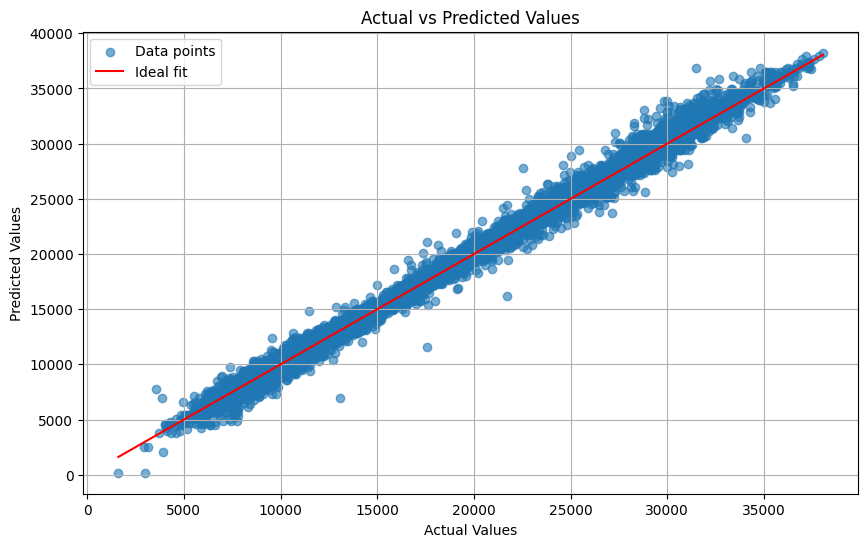

In [190]:
printResults(loadModel("ModelWithFeatures"),X2_test_tensor,y2_test_tensor,error=1000)
plt.show()